### 사이킷런 Wrapper XGBoost 개요 및 적용 
Boosting 이란?
- 여러 개의 약한 의사결정나무(Decision Tree)를 조합해서 사용하는 앙상블(Ensemble) 기법 중 하나
즉, 약한 예측 모형들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측모형을 만든다.

XGBoost 란?
- XGBoost는 Extreme Gradient Boosting의 약자이다. 해석하면 극한 변화도(경사도) 부스팅
- Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost 가 대표적
- 이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost 이다.
- Regression, Classification 문제를 모두 지원하며, 성능과 자원 효율이 좋아서, 인기 있게 사용되는 알고리즘 이다.

XGBoost의 장점
- GBM 대비 빠른 수행시간
- 병렬 처리로 학습, 분류 속도가 빠르다.
- 과적합 규제(Regularization)
- 표준 GBM 경우 과적합 규제기능이 없으나, XGBoost는 자체에 과적합 규제 기능으로 강한 내구성 지닌다.
- 분류와 회귀영역에서 뛰어난 예측 성능 발휘
- 즉, CART(Classification and regression tree) 앙상블 모델을 사용
- Early Stopping(조기 종료) 기능이 있음
- 다양한 옵션을 제공하며 Customizing이 용이하다.
- Missing Values : 결측치를 내부적으로 처리해준다. 실제로 kaggle에 적용해보는 과정에서 편리함


In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data = X_features, columns = dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
print(dataset.target_names)
print(cancer_df.target.value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [4]:
X_train,X_test,y_train,y_test = train_test_split(X_features,y_label,test_size = 0.2, random_state = 11)
print(X_train.shape,X_test.shape)

(455, 30) (114, 30)


In [5]:
# %pip install xgboost

In [6]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix
def get_clf_eval(y_test,pred=None,pred_proba=None):
    con_mat = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    print(f'오차행렬 : \n{con_mat}\n\nTN = {con_mat[0, 0]}, FP = {con_mat[0, 1]}\nFN = {con_mat[1, 0]}, TP = {con_mat[1, 1]}\n')
    print(f'정확도 : {acc:.4f}, 정밀도 : {pre:.4f}, 재현율 : {rec:.4f}, f1 점수 : {f1:.4f}, roc_auc : {roc_auc:.4f}')



In [10]:
from xgboost import XGBClassifier

evals = [(X_test,y_test)]
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train,y_train, early_stopping_rounds= 100, eval_set=evals,eval_metric = 'logloss',verbose = True)
w_preds = xgb_wrapper.predict(X_test)
w_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]


[0]	validation_0-logloss:0.61282
[1]	validation_0-logloss:0.54112
[2]	validation_0-logloss:0.48139
[3]	validation_0-logloss:0.42984
[4]	validation_0-logloss:0.38936
[5]	validation_0-logloss:0.35109
[6]	validation_0-logloss:0.32014
[7]	validation_0-logloss:0.29190
[8]	validation_0-logloss:0.26556
[9]	validation_0-logloss:0.24385
[10]	validation_0-logloss:0.22614
[11]	validation_0-logloss:0.21025
[12]	validation_0-logloss:0.19319
[13]	validation_0-logloss:0.17976
[14]	validation_0-logloss:0.16620
[15]	validation_0-logloss:0.15614
[16]	validation_0-logloss:0.14731
[17]	validation_0-logloss:0.13762
[18]	validation_0-logloss:0.12923
[19]	validation_0-logloss:0.12281
[20]	validation_0-logloss:0.11820
[21]	validation_0-logloss:0.11244
[22]	validation_0-logloss:0.10646
[23]	validation_0-logloss:0.10116
[24]	validation_0-logloss:0.09627
[25]	validation_0-logloss:0.09168
[26]	validation_0-logloss:0.08974
[27]	validation_0-logloss:0.08500
[28]	validation_0-logloss:0.08140
[29]	validation_0-loglos

In [8]:
get_clf_eval(y_test,w_preds,w_preds_proba)

오차행렬 : 
[[36  2]
 [ 0 76]]

TN = 36, FP = 2
FN = 0, TP = 76

정확도 : 0.9825, 정밀도 : 0.9744, 재현율 : 1.0000, f1 점수 : 0.9870, roc_auc : 1.0000


In [12]:
dataset.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

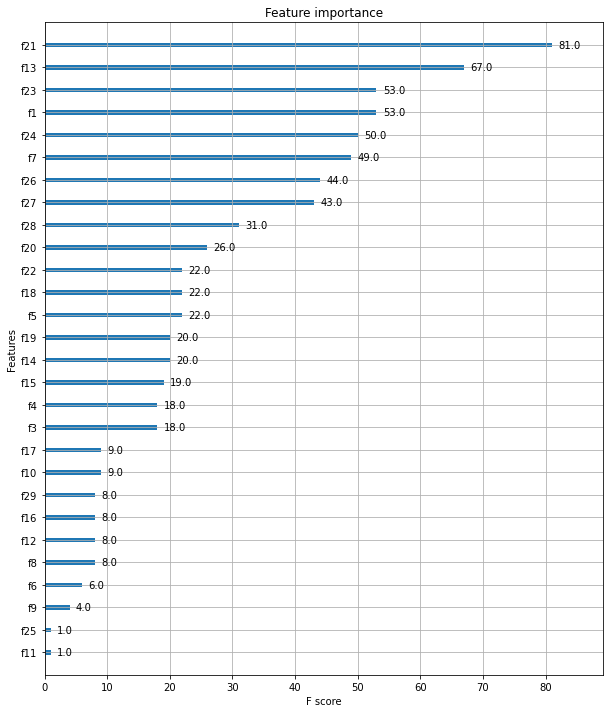

In [11]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize = (10,12))
plot_importance(xgb_wrapper,ax=ax)

